# Importing libraries and dependencies

In [6]:
import numpy as np
import networkx as nx
from qiskit import QuantumCircuit
from qiskit import visualization
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from itertools import combinations

## Setting the initial graph

In [414]:
n=5
g = nx.Graph()
g.add_nodes_from([i for i in range(1, n+1)])
edge_list = [(1,2,1), (1,5,1), (2,3,1), (2,4,1), (2,5,1), (3,4,1), (4,5,1)]
g.add_weighted_edges_from(edge_list)
colors = ['c' for node in g.nodes()]
pos = nx.spring_layout(g)
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

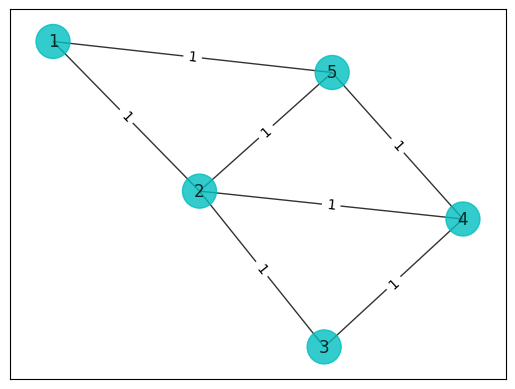

In [415]:
draw_graph(g, colors, pos)

In [344]:
def initial_state_preparation(cirq, n_qubits, n_colors):
    for q in range(n_qubits * n_colors):
        cirq.h(q)
    return cirq

In [356]:
def one_color(cirq, n_qubits, n_colors, C, gamma):
    for v in range(1, n_qubits + 1):
        indices = [(v-1) * n_colors + i for i in range(n_colors)]
        for i in indices:
            for j in indices:
                if i == j:
                    cirq.rz(2 * gamma * C, i)  # Apply RZ with phase based on the Hamiltonian coefficient
                else:
                    cirq.cx(i, j)
                    cirq.rz(2 * gamma * C, j)
                    cirq.cx(i, j)
    return cirq
    # qc1.draw('mpl')

In [361]:
def vertex_color(cirq, n_colors, edges, gamma, D ):
    for (u, v) in edges:
        for c in range(n_colors):
            idx_u = (u - 1) * n_colors + c
            idx_v = (v - 1) * n_colors + c
            cirq.cx(idx_u, idx_v)
            cirq.rz(2 * gamma * D, idx_v)  # Applying a phase dependent on the edge existence
            cirq.cx(idx_u, idx_v)
    return cirq

In [363]:
def mix_layer(cirq,n_qubits, n_color, beta):
    for q in range(n * n_colors):
        cirq.rx(2 * beta, q)

## Circuit with depth = 1

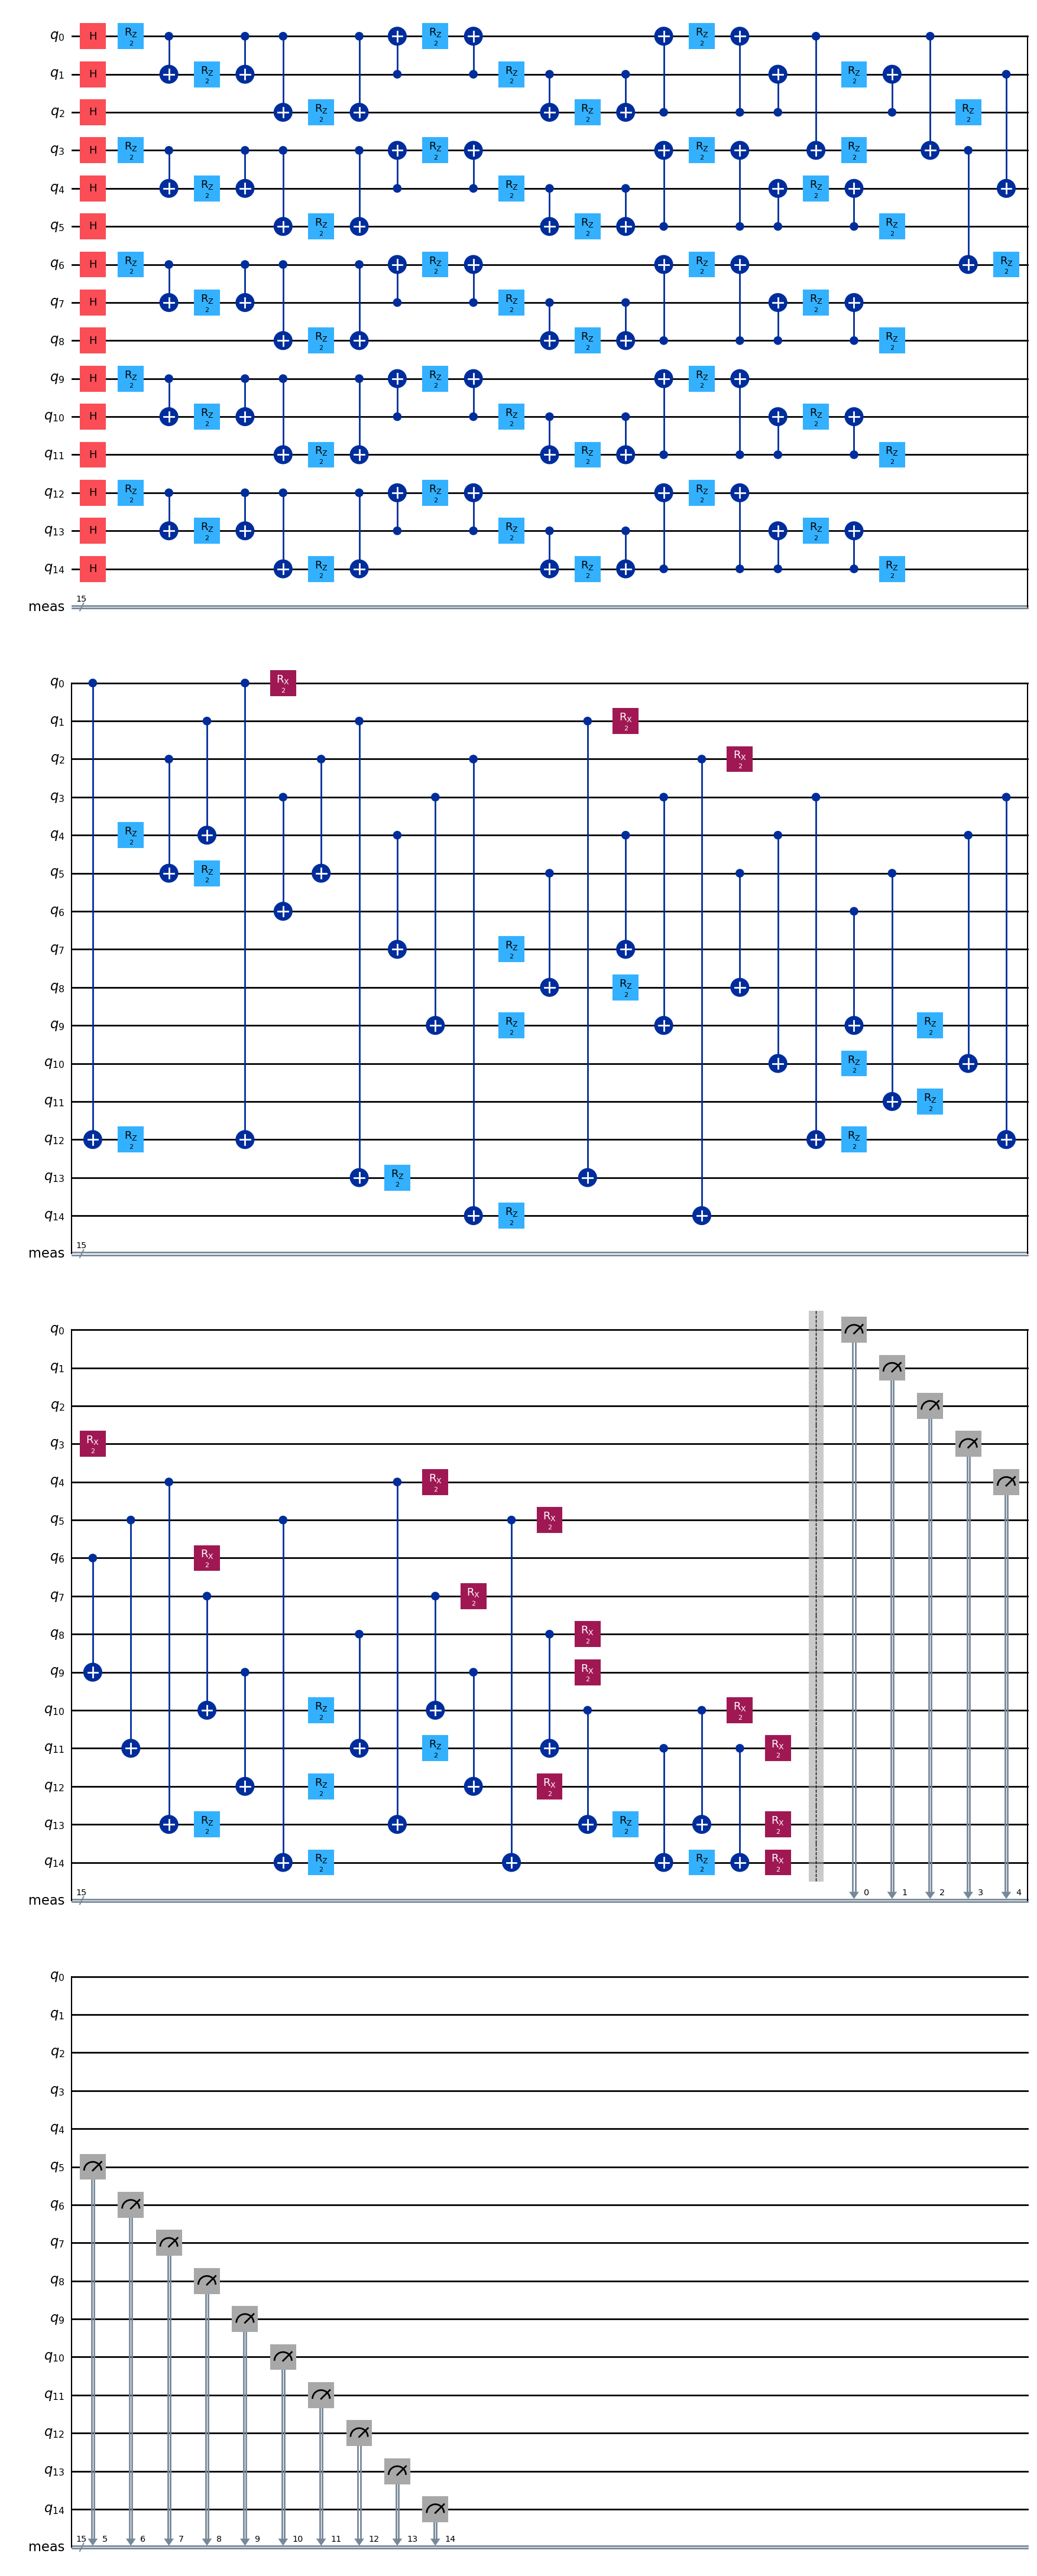

In [544]:
n_qubits = 5
n_colors = 3
qubits_total = n_qubits * n_colors
C = 1
D =1
edges = [(1,2), (1,5), (2,3), (2,4), (2,5), (3,4), (4,5)]
gamma = 1
beta =1
qc3 = QuantumCircuit(qubits_total)
initial_state_preparation(qc3, n_qubits, n_colors)
one_color(qc3, n_qubits, n_colors, C, gamma)
vertex_color(qc3, n_colors, edges, gamma, D )
mix_layer(qc3, n_qubits, n_colors, beta)
qc3.measure_all()
qc3.draw('mpl')

In [395]:
service = QiskitRuntimeService(channel="ibm_quantum", token="") #add your IBMQ token here.

def create_cirq(n_qubits, n_colors, edges, C, D, depth, params):
    gammas = [j for i, j in enumerate(params) if i % 2 == 0]
    betas = [j for i, j in enumerate(params) if i % 2 == 1]
    qubits_total = n_qubits * n_colors
    qc3 = QuantumCircuit(qubits_total)
    initial_state_preparation(qc3, n_qubits, n_colors)
    for i in range(depth):
        one_color(qc3, n_qubits, n_colors, C,  gammas[i])
        vertex_color(qc3, n_colors, edges,  gammas[i], D )
        mix_layer(qc3, n_qubits, n_colors, betas[i])
    qc3.measure_all()
    
    backend = Aer.get_backend('qasm_simulator')
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(qc3)
    sampler = Sampler(backend=backend)
    job = sampler.run([(isa_circuit,)], shots=1024)
    job_result = job.result()
    pub_result = job.result()[0]
    counts = pub_result.data.meas.get_counts()
    return  counts

In [504]:

def cost_function( params):    
    counts = create_cirq(n_qubits, n_colors, edges, C, D, depth, params)
    total_cost = 0
    # Iterate over each bit string in the counts dictionary
    nn=0
    for bit_string, count in counts.items():
        
        cost = 0
        # First term: ensure exactly one color per vertex
        for v in range(n_qubits):
            color_bits = bit_string[v*3:(v+1)*3]  # Extract bits for vertex v
            sum_x_vc = sum(int(bit) for bit in color_bits)  # Sum colors for vertex v
            cost += C * (1 - sum_x_vc) ** 2
            
        # Second term: no two adjacent vertices share the same color
        for (u, v) in edges:
            for c in range(3):
                # Extract color bits for vertices u and v
                x_uc = int(bit_string[u*3 + c])
                x_vc = int(bit_string[v*3 + c])
                cost += D * x_uc * x_vc #all weights are 1
        
        # Weight the cost by the number of occurrences of the bit string
        total_cost += cost * count
        # nn=nn+1
        # print(bit_string)
        # print(total_cost)
        # print(nn)
        
    return -total_cost

In [506]:
from scipy.optimize import minimize
n_qubits = 5
n_colors = 3
C = 1
D =1
edges = [(0, 1), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (3, 4)]
gamma = 1
beta = 1
depth =1 #p-value
params = np.random.uniform(-np.pi, np.pi, 2 * depth)

optimal_params = None
optimal_val = np.inf
out = minimize(cost_function, x0=params, method='COBYLA', options={'maxiter':200, 'disp':True})
print(out['fun'])
if out['fun'] < optimal_val:
    optimal_params = out['x']
    optimal_val = out['fun']

-17321.0


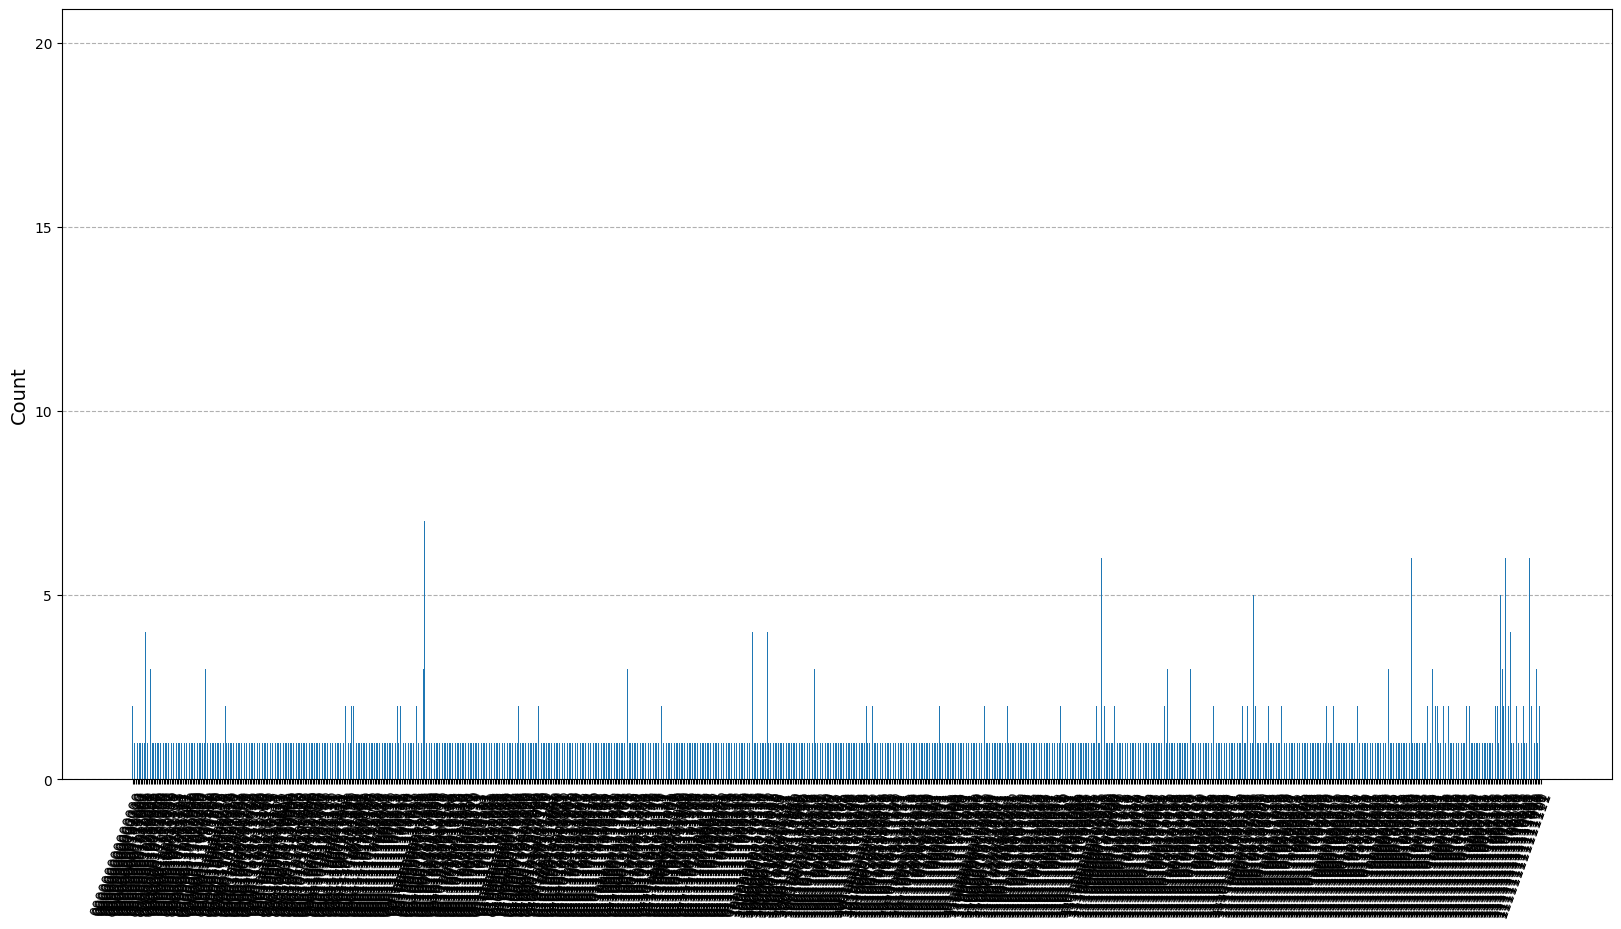

In [521]:
figsize = (20,10)
f = create_cirq(n_qubits, n_colors, edges, C, D, depth, optimal_params)
visualization.plot_histogram(f, figsize=figsize, bar_labels=False, legend=None)

In [529]:

depth =10 #p-value
params = np.random.uniform(-np.pi, np.pi, 2 * depth)

optimal_params = None
optimal_val = np.inf
out = minimize(cost_function, x0=params, method='COBYLA', options={'maxiter':200, 'disp':True})
print(out['fun'])
if out['fun'] < optimal_val:
    optimal_params = out['x']
    optimal_val = out['fun']

# colors = ["r" if best_solution[i] == '0' else "c" for i in range(n_nodes)]
# draw_graph(g, colors, pos)

-37438.0


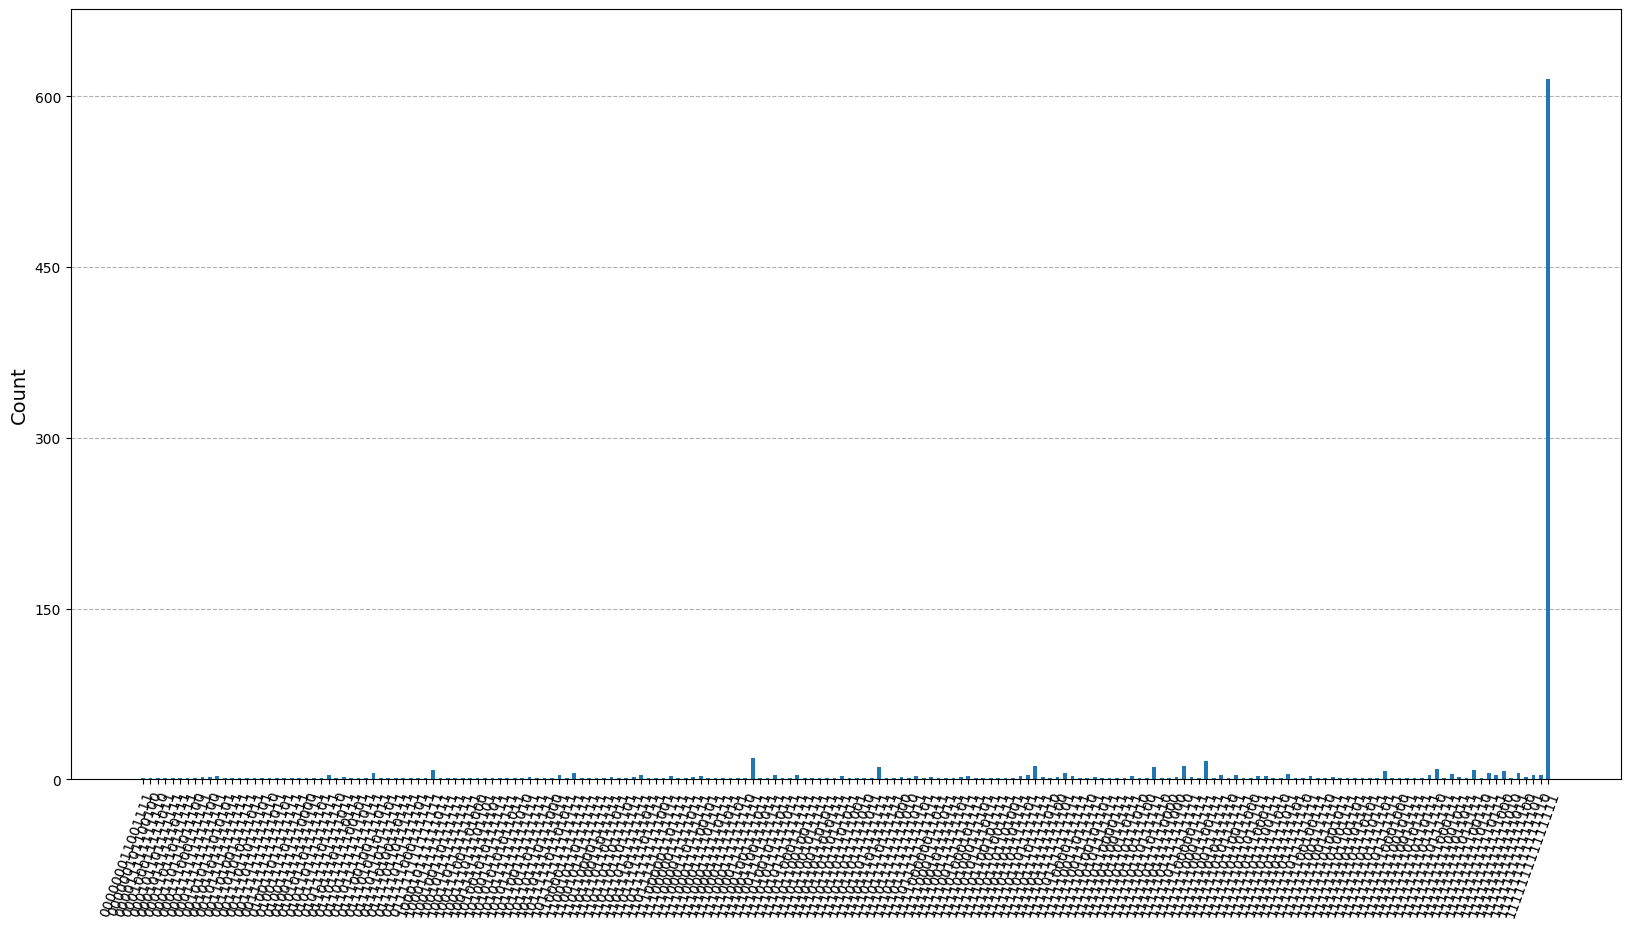

In [530]:
figsize = (20,10)
f = create_cirq(n_qubits, n_colors, edges, C, D, depth, optimal_params)
visualization.plot_histogram(f, figsize=figsize, bar_labels=False, legend=None)

In [531]:

depth =20 #p-value
params = np.random.uniform(-np.pi, np.pi, 2 * depth)

optimal_params = None
optimal_val = np.inf
out = minimize(cost_function, x0=params, method='COBYLA', options={'maxiter':200, 'disp':True})
print(out['fun'])
if out['fun'] < optimal_val:
    optimal_params = out['x']
    optimal_val = out['fun']

-11273.0


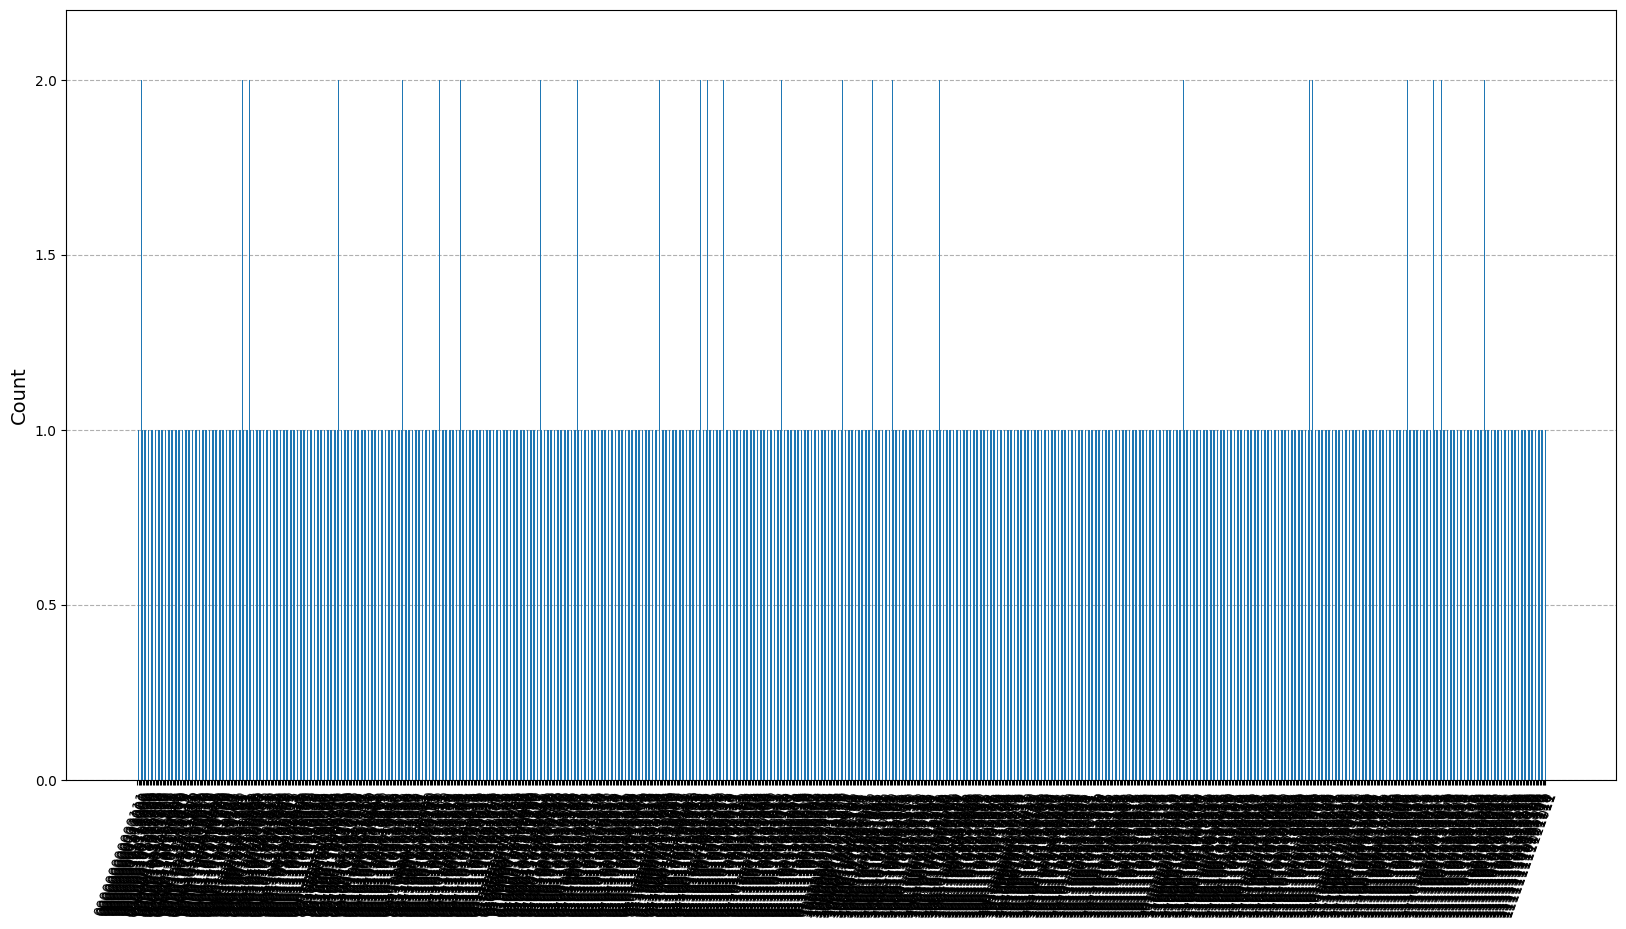

In [532]:
figsize = (20,10)
f = create_cirq(n_qubits, n_colors, edges, C, D, depth, optimal_params)
visualization.plot_histogram(f, figsize=figsize, bar_labels=False, legend=None)

In [533]:
depth =30 #p-value
params = np.random.uniform(-np.pi, np.pi, 2 * depth)

optimal_params = None
optimal_val = np.inf
out = minimize(cost_function, x0=params, method='COBYLA', options={'maxiter':200, 'disp':True})
print(out['fun'])
if out['fun'] < optimal_val:
    optimal_params = out['x']
    optimal_val = out['fun']

-11161.0


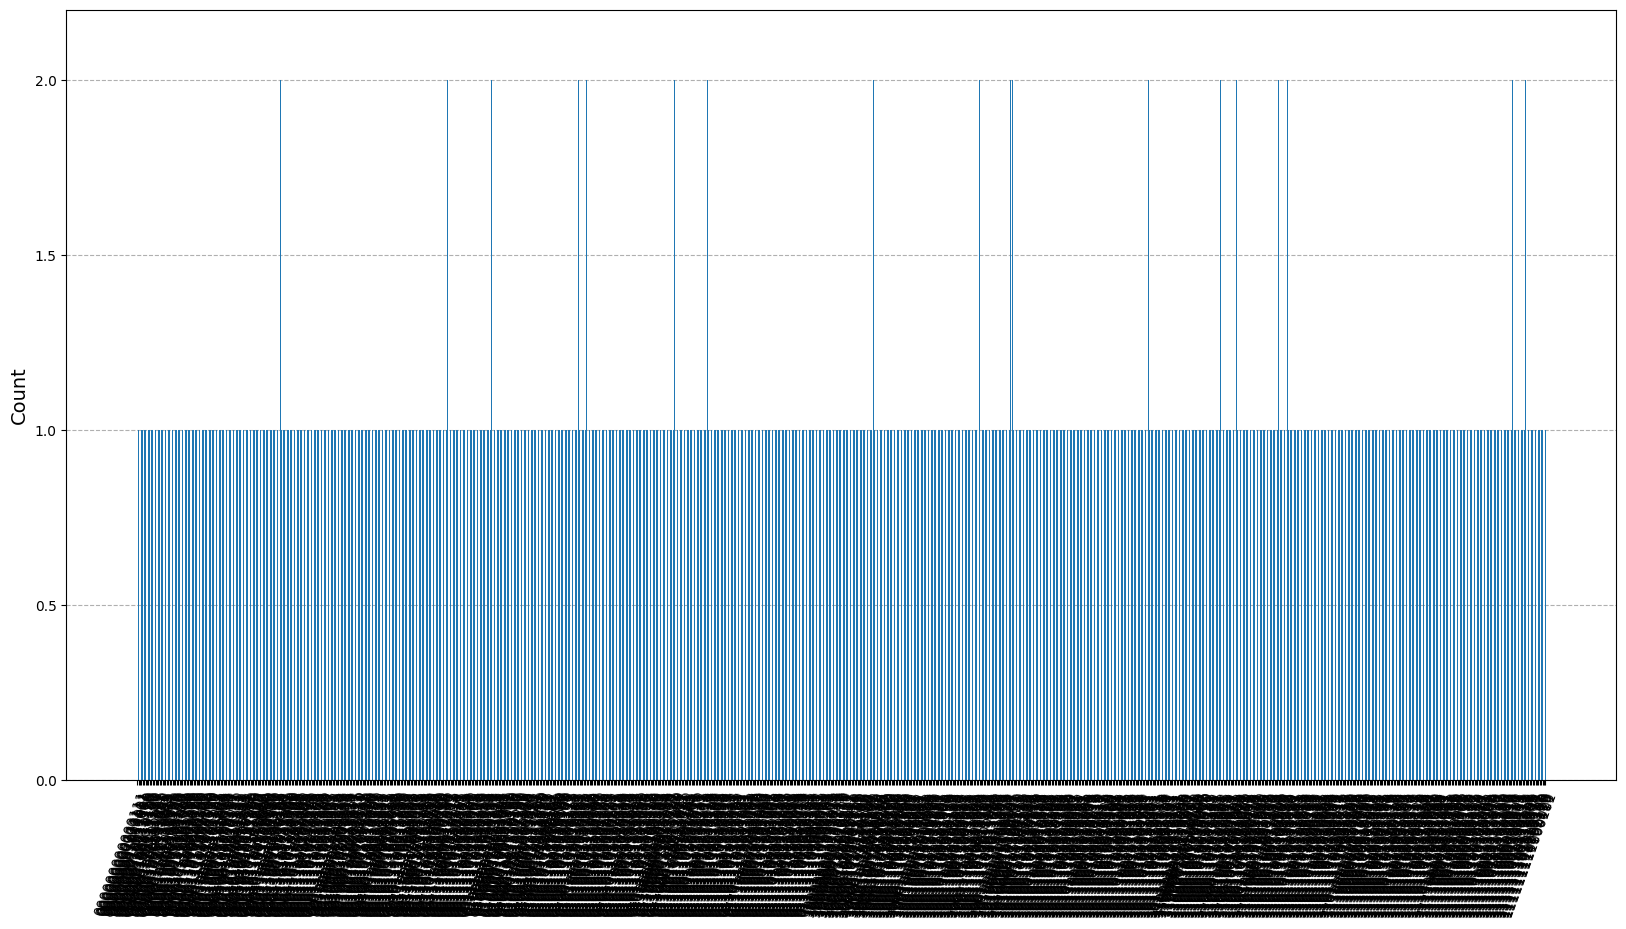

In [534]:
figsize = (20,10)
f = create_cirq(n_qubits, n_colors, edges, C, D, depth, optimal_params)
visualization.plot_histogram(f, figsize=figsize, bar_labels=False, legend=None)

In [535]:
depth =40 #p-value
params = np.random.uniform(-np.pi, np.pi, 2 * depth)

optimal_params = None
optimal_val = np.inf
out = minimize(cost_function, x0=params, method='COBYLA', options={'maxiter':200, 'disp':True})
print(out['fun'])
if out['fun'] < optimal_val:
    optimal_params = out['x']
    optimal_val = out['fun']

-11466.0


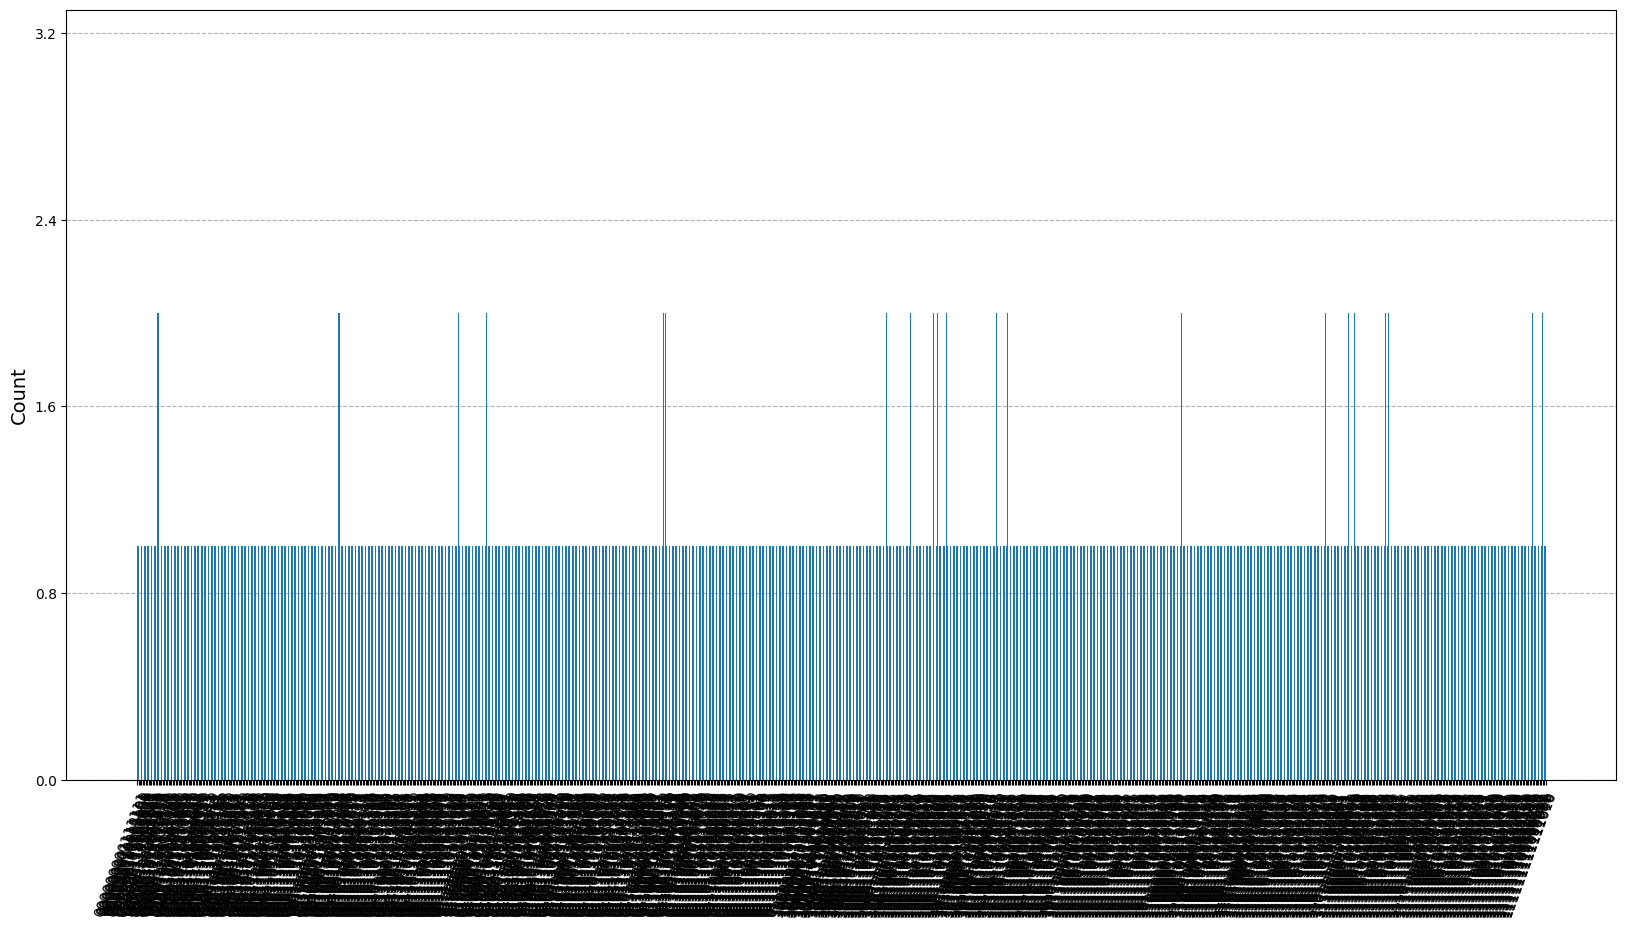

In [536]:
figsize = (20,10)
f = create_cirq(n_qubits, n_colors, edges, C, D, depth, optimal_params)
visualization.plot_histogram(f, figsize=figsize, bar_labels=False, legend=None)

In [547]:
depth =50 #p-value
params = np.random.uniform(-np.pi, np.pi, 2 * depth)

optimal_params = None
optimal_val = np.inf
out = minimize(cost_function, x0=params, method='COBYLA', options={'maxiter':200, 'disp':True})
print(out['fun'])
if out['fun'] < optimal_val:
    optimal_params = out['x']
    optimal_val = out['fun']

-11316.0


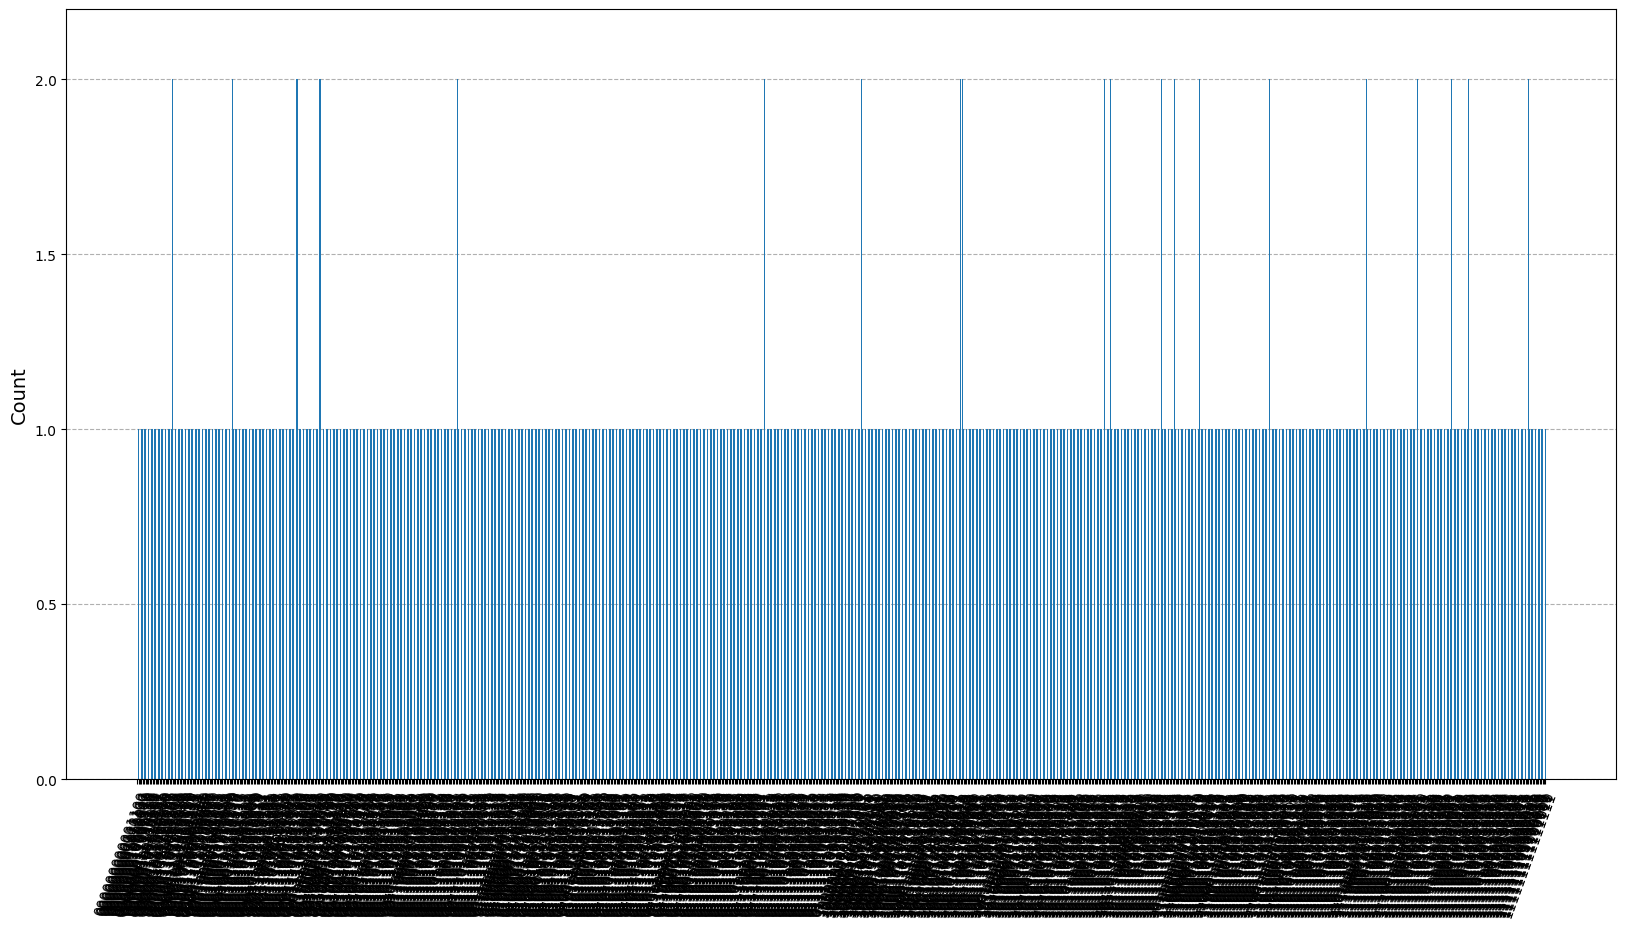

In [548]:
figsize = (20,10)
f = create_cirq(n_qubits, n_colors, edges, C, D, depth, optimal_params)
visualization.plot_histogram(f, figsize=figsize, bar_labels=False, legend=None)

In [549]:
depth =60 #p-value
params = np.random.uniform(-np.pi, np.pi, 2 * depth)

optimal_params = None
optimal_val = np.inf
out = minimize(cost_function, x0=params, method='COBYLA', options={'maxiter':200, 'disp':True})
print(out['fun'])
if out['fun'] < optimal_val:
    optimal_params = out['x']
    optimal_val = out['fun']

-11300.0


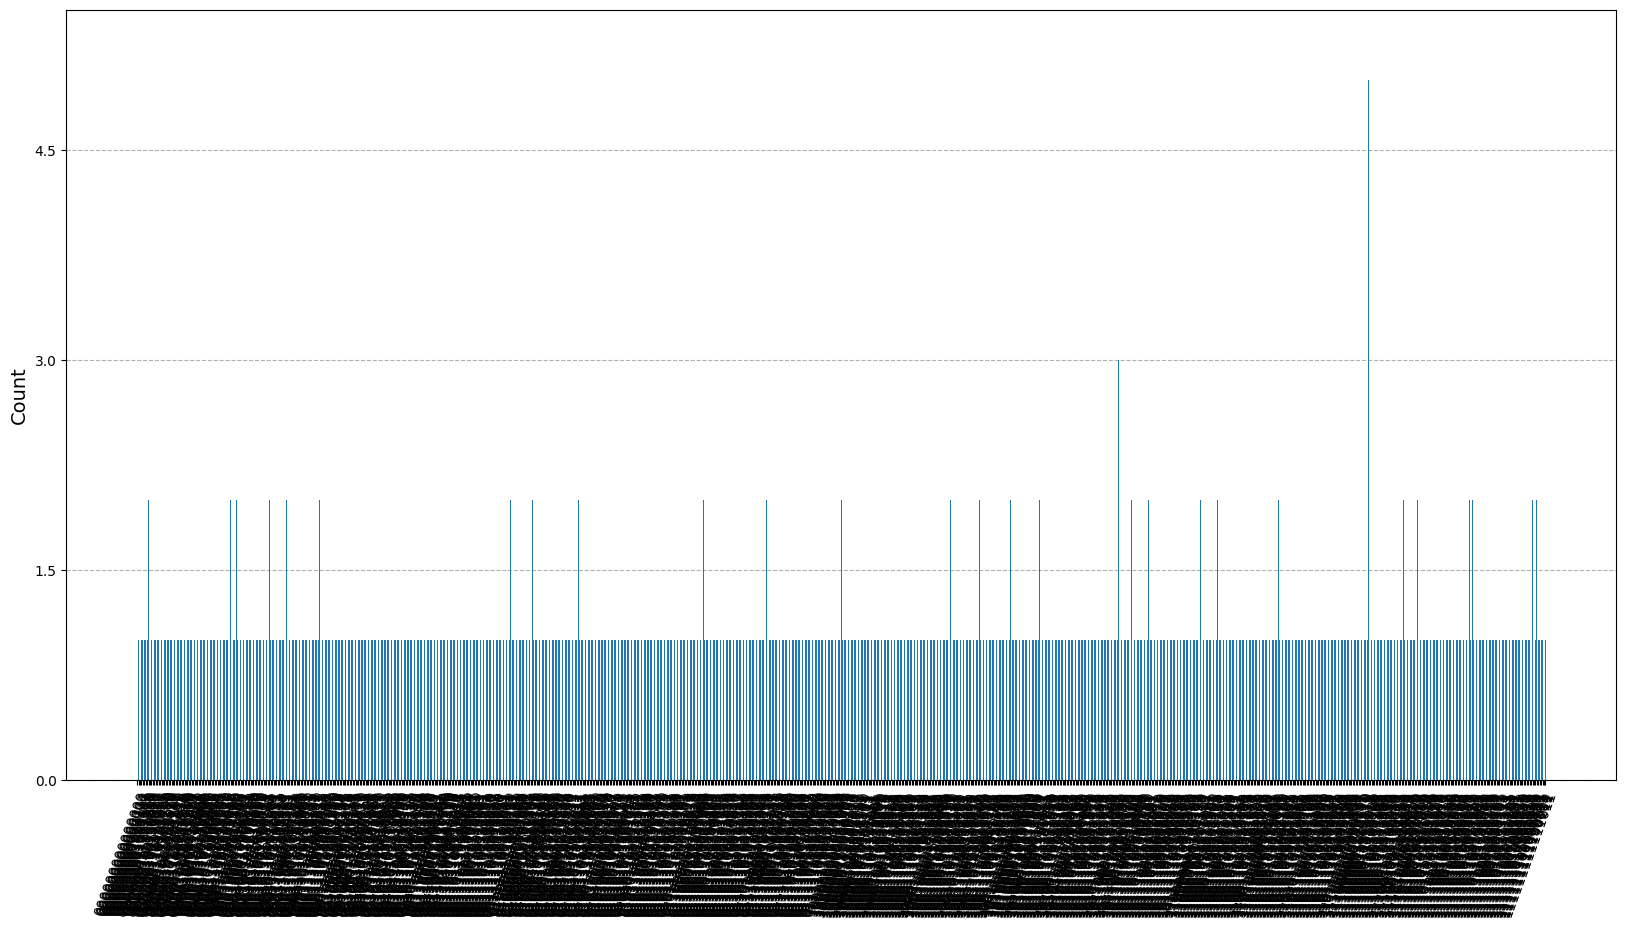

In [550]:
figsize = (20,10)
f = create_cirq(n_qubits, n_colors, edges, C, D, depth, optimal_params)
visualization.plot_histogram(f, figsize=figsize, bar_labels=False, legend=None)

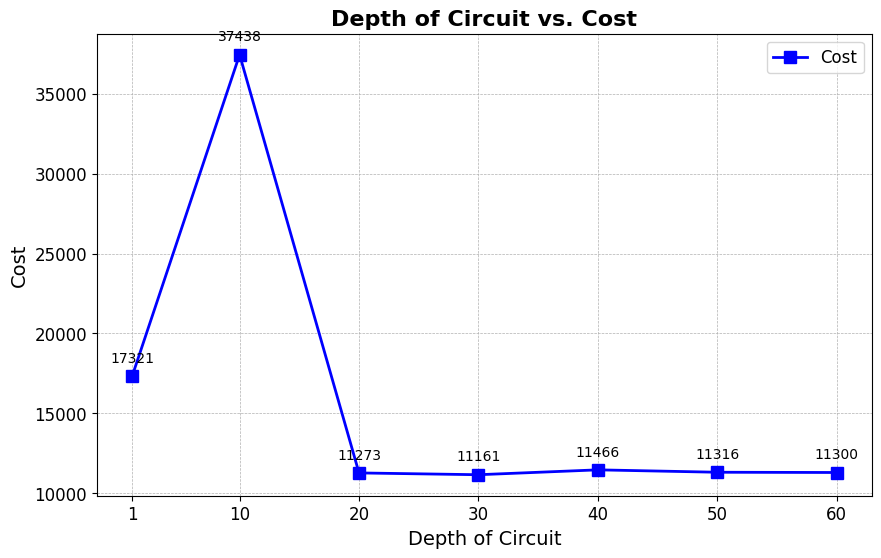

In [552]:
#Cost convergency

# Data
depth_of_circuit = [1, 10, 20, 30, 40, 50, 60]
costs = [17321, 37438, 11273, 11161, 11466, 11316, 11300]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(depth_of_circuit, costs, marker='s', color='blue', linestyle='-', linewidth=2, markersize=8)

# Add title and labels
plt.title('Depth of Circuit vs. Cost', fontsize=16, fontweight='bold')
plt.xlabel('Depth of Circuit', fontsize=14)
plt.ylabel('Cost', fontsize=14)

# Customize the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the ticks
plt.xticks(depth_of_circuit, fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(['Cost'], fontsize=12)

# Add annotation for each point
for i, txt in enumerate(costs):
    plt.annotate(txt, (depth_of_circuit[i], costs[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

# Save the plot as a high-quality PNG file
plt.savefig('depth_vs_cost.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
